## Проект: «Лаборатории исследований гражданского общества». Государственные деньги у НКО

В нашем распоряжении есть дамп данных обо всех НКО России, в котором содержится информация о получении государственных грантов,госконтрактов и субсидий, регионе и дате регистрации, а также ОКВЭД (классификатор экономической деятельности).
НКО хотят повысить свои шансы на получение гранта. Для этого им важно понять, что именно может повлиять на это.
Наша цель — спрогнозировать вероятность получения грантов от государства/госконтрактов для организации в зависимости от её характеристик.

### Задача:
проверить, есть ли зависимость вероятности получения
грантов от государства/госконтрактов:
1. от региона регистрации организации;
2. от возраста организации;
3. от экономической деятельности организации.

4. Предсказать вероятность получения грантов от государства/госконтрактов для новых организаций.



Импортируем необходимые библиотеки:

In [326]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pandas import json_normalize
from datetime import datetime
import pytz
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn import model_selection #методы разделения и валидации
from sklearn.preprocessing  import LabelEncoder
import plotly.express as px
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline

## Знакомство с данными

Десериализуем данные:

In [185]:
file_names = [f'data/ngo_dump_{str(i).zfill(2)}.json' for i in range(1,16)]
dfs = []
for file_name in file_names:
    print(f'Read file:{file_name}')
    data = []
    try:
        with open(file_name, 'r', encoding='utf-8') as file:
            for line in file:
                if line.strip():
                    data.append(json.loads(line))

# Если это один объект, оборачиваем в список
        if isinstance(data, dict):
            data = [data]
        elif not isinstance(data, list):
            raise ValueError("Неподдерживаемый формат данных")
        df_temp = json_normalize(data)
        dfs.append(df_temp)
    except Exception as e:
        print(f"Error during reading file {file_name}:{e}")
if dfs:
    df = pd.concat(dfs, ignore_index=True)
    print(f'Df created. Strings quantity:{len(df)}')
else:
    print('Failed to create DataFrame')

print(df.head())
        

Read file:data/ngo_dump_01.json
Read file:data/ngo_dump_02.json
Read file:data/ngo_dump_03.json
Read file:data/ngo_dump_04.json
Read file:data/ngo_dump_05.json
Read file:data/ngo_dump_06.json
Read file:data/ngo_dump_07.json
Read file:data/ngo_dump_08.json
Read file:data/ngo_dump_09.json
Read file:data/ngo_dump_10.json
Read file:data/ngo_dump_11.json
Read file:data/ngo_dump_12.json
Read file:data/ngo_dump_13.json
Read file:data/ngo_dump_14.json
Read file:data/ngo_dump_15.json
Df created. Strings quantity:747034
  minjustRegNum       regionName  logo  \
0    7814061218  Санкт-Петербург  None   
1    7714017452           Москва  None   
2    7814170160  Санкт-Петербург  None   
3          None           Москва  None   
4    7814052913  Санкт-Петербург  None   

                                            fullName  dateReg  \
0  МЕЖРЕГИОНАЛЬНАЯ АНТРОПОСОФСКАЯ МЕДИЦИНСКАЯ АСС...      NaN   
1  ФОНД "СОДЕЙСТВИЕ ДУХОВНОМУ РАЗВИТИЮ ЧЕЛОВЕКА "...      NaN   
2  КОЛЛЕГИЯ АДВОКАТОВ "САНКТ-ПЕТЕРБУ

In [186]:
df = pd.DataFrame(df)
df.head()

,minjustRegNum,regionName,logo,fullName,dateReg,minjustForm,charter,minjustStatus,ogrn,egrulStatus,...,incomeDetail.fedSubsidies.2012.sum,incomeDetail.fedSubsidies.2012.count,incomeDetail.contracts223.2004.sum,incomeDetail.contracts223.2004.count,incomeDetail.fedSubsidies.2007.sum,incomeDetail.fedSubsidies.2007.count,incomeDetail.fedSubsidies.2006.sum,incomeDetail.fedSubsidies.2006.count,incomeDetail.fedSubsidies.2005.sum,incomeDetail.fedSubsidies.2005.count
0,7814061218,Санкт-Петербург,None,МЕЖРЕГИОНАЛЬНАЯ АНТРОПОСОФСКАЯ МЕДИЦИНСКАЯ АСС...,NaN,"Объединения (союз, ассоциация) юридических лиц",None,Зарегистрирована,1207800141790,Действует,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7714017452,Москва,None,"ФОНД ""СОДЕЙСТВИЕ ДУХОВНОМУ РАЗВИТИЮ ЧЕЛОВЕКА ""...",NaN,Некоммерческий фонд,None,Зарегистрирована,1207700349152,Действует,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7814170160,Санкт-Петербург,None,"КОЛЛЕГИЯ АДВОКАТОВ ""САНКТ-ПЕТЕРБУРГСКАЯ КОЛЛЕГ...",NaN,Коллегия адвокатов,None,Зарегистрирована,1207800011430,Действует,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,None,Москва,None,"ТОВАРИЩЕСТВО СОБСТВЕННИКОВ НЕДВИЖИМОСТИ ""ЛУГИН...",NaN,None,None,None,1207700348976,Действует,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7814052913,Санкт-Петербург,None,"АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ""ЦЕНТР С...",NaN,Автономная некоммерческая организация,None,Зарегистрирована,1207800081500,Действует,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747034 entries, 0 to 747033
Columns: 198 entries, minjustRegNum to incomeDetail.fedSubsidies.2005.count
dtypes: bool(1), float64(142), int64(5), object(50)
memory usage: 1.1+ GB


Получилось 198 признаков. Не все из них пригодятся для построения прогноза. 

Характеристики открытых данных можно найти здесь https://github.com/infoculture/openngo-data-reference/wiki/Характеристики-и-расшифровки-открытых-данных

Скачаем дополнительную таблицу с более точными кодами правовой формы (ОКОПФ) для фондов всех видов.

In [188]:
f_codes = pd.read_csv('data/foundations_codes.csv')

In [189]:
f_codes.head()
f_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21920 entries, 0 to 21919
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      21920 non-null  object 
 1   ogrn      21858 non-null  float64
 2   status    21920 non-null  object 
 3   region    21920 non-null  object 
 4   okopf     21920 non-null  object 
 5   okopf_id  21920 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 1.0+ MB


In [190]:
f_codes['okopf_id'].unique()

array([70400, 70401, 70403, 70402, 70404], dtype=int64)

Выберем из нашего основного датасета те признаки, которые могут предположительно могут характеризовать НКО, и на которые можно опираться при построении прогноза. Почти все признаки являются категориальными, так как состоят из классификаторов.

In [191]:
cols_needed = ['regionName','fullName','ogrn', 'egrulStatus',
       'regionCode',
       'hasRegionalSupport', 'addOkved',
       'statusDetail.shortName','mainOkved.name', 'mainOkved.code',
       'mainOkved.version', 'incomeDetail.grants.totalCount',
       'incomeDetail.grants.totalSum', 'incomeDetail.fedSubsidies.totalCount',
       'incomeDetail.fedSubsidies.totalSum',
       'incomeDetail.contracts44.totalCount',
       'incomeDetail.contracts44.totalSum',
       'incomeDetail.contracts223.totalCount',
       'incomeDetail.contracts223.totalSum',
       'incomeDetail.contracts94.totalCount',
       'incomeDetail.contracts94.totalSum',
       'incomeTotal', 'originDate.$date',
       'dateOgrn.$date', 'dateLiquid.$date',
       'dateReg.$date','minjustForm',
       'okato.code','okato.name',
       'okfs.code','okfs.name',
       'okogu.code','okogu.name',
       'oktmo.code','oktmo.name',
       'opf.code','opf.name']

In [192]:
df = df[cols_needed]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747034 entries, 0 to 747033
Data columns (total 37 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   regionName                            747009 non-null  object 
 1   fullName                              747034 non-null  object 
 2   ogrn                                  747034 non-null  object 
 3   egrulStatus                           747034 non-null  object 
 4   regionCode                            747034 non-null  object 
 5   hasRegionalSupport                    747034 non-null  bool   
 6   addOkved                              747034 non-null  object 
 7   statusDetail.shortName                747034 non-null  object 
 8   mainOkved.name                        542353 non-null  object 
 9   mainOkved.code                        542353 non-null  object 
 10  mainOkved.version                     747034 non-null  object 
 11  

➔ ogrn — ключевое поле, в том числе для соединения с другими наборами
данных, уникальный номер, присваиваемый организации при её
регистрации, и он всегда неизменен.
➔  В поле egrulStatus отмечено, действующая ли организация или ликвидированная
➔ Для целей задачи данные из полей contracts44, contracts223,
contracts94 можем суммировать (это разные формы контрактов, но это
имеет значение только для заказчика).

Видим, что признак addOkved представляет из себя список словарей с дополнительными кодами ОКВЕД. Сформируем из него признак, в котором значением будет список дополнительных классификаторов. Пустые списки заменим на отсутствующие значения

## Очистка и предобработка данных

Посмотрим, много ли отсутствующих значений в признаках:

In [193]:
print(df.isnull().sum().sort_values(ascending=False))
cols_null_percent = df.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

oktmo.name                              471320
dateReg.$date                           425618
okato.name                              408814
okogu.name                              399608
oktmo.code                              399597
okogu.code                              399597
okfs.name                               399597
okfs.code                               399597
okato.code                              399597
dateLiquid.$date                        347073
minjustForm                             284732
mainOkved.name                          204681
mainOkved.code                          204681
opf.code                                 45209
opf.name                                   415
regionName                                  25
incomeDetail.contracts44.totalSum            0
incomeDetail.grants.totalSum                 0
ogrn                                         0
egrulStatus                                  0
regionCode                                   0
hasRegionalSu

oktmo.name          63.092175
dateReg.$date       56.974381
okato.name          54.724952
okogu.name          53.492612
okato.code          53.491140
okfs.code           53.491140
okfs.name           53.491140
okogu.code          53.491140
oktmo.code          53.491140
dateLiquid.$date    46.460134
minjustForm         38.114999
mainOkved.name      27.399155
mainOkved.code      27.399155
opf.code             6.051800
opf.name             0.055553
regionName           0.003347
dtype: float64

dateReg: дата регистрации организаций - указывается только для организаций, зарегистрированных до 2002 года, поэтому в этом признаке много пропущенных значений. То же касается dateLiquid.$date - дата ликвидации организации.

Удалим неинформативные признаки с большим количеством пропусков (больше 20 процентов), сохраним dateReg, dateLiquid, mainOkved.name, mainOkved.code, так как оквэд является критичным для нашей задачи

In [194]:
df = df.drop(columns=['oktmo.name','okato.name','okogu.name','okato.code','okfs.name','okfs.code','oktmo.code',
                      'okogu.code','minjustForm'])

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747034 entries, 0 to 747033
Data columns (total 28 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   regionName                            747009 non-null  object 
 1   fullName                              747034 non-null  object 
 2   ogrn                                  747034 non-null  object 
 3   egrulStatus                           747034 non-null  object 
 4   regionCode                            747034 non-null  object 
 5   hasRegionalSupport                    747034 non-null  bool   
 6   addOkved                              747034 non-null  object 
 7   statusDetail.shortName                747034 non-null  object 
 8   mainOkved.name                        542353 non-null  object 
 9   mainOkved.code                        542353 non-null  object 
 10  mainOkved.version                     747034 non-null  object 
 11  

In [196]:
df.head()

,regionName,fullName,ogrn,egrulStatus,regionCode,hasRegionalSupport,addOkved,statusDetail.shortName,mainOkved.name,mainOkved.code,...,incomeDetail.contracts223.totalSum,incomeDetail.contracts94.totalCount,incomeDetail.contracts94.totalSum,incomeTotal,originDate.$date,dateOgrn.$date,dateLiquid.$date,dateReg.$date,opf.code,opf.name
0,Санкт-Петербург,МЕЖРЕГИОНАЛЬНАЯ АНТРОПОСОФСКАЯ МЕДИЦИНСКАЯ АСС...,1207800141790,Действует,78,False,[],Действующая,Деятельность профессиональных членских организ...,94.12,...,0.0,0,0.0,0.0,2020-10-30T00:00:00.000Z,2020-10-30T00:00:00.000Z,NaN,NaN,20600,Ассоциации (союзы)
1,Москва,"ФОНД ""СОДЕЙСТВИЕ ДУХОВНОМУ РАЗВИТИЮ ЧЕЛОВЕКА ""...",1207700349152,Действует,77,False,"[{'name': 'Издание книг', 'code': '58.11', 've...",Действующая,"Предоставление прочих финансовых услуг, кроме ...",64.99,...,0.0,0,0.0,0.0,2020-09-23T00:00:00.000Z,2020-09-23T00:00:00.000Z,NaN,NaN,70400,Фонды
2,Санкт-Петербург,"КОЛЛЕГИЯ АДВОКАТОВ ""САНКТ-ПЕТЕРБУРГСКАЯ КОЛЛЕГ...",1207800011430,Действует,78,False,[],Действующая,Деятельность в области права,69.10,...,0.0,0,0.0,0.0,2020-02-03T00:00:00.000Z,2020-02-03T00:00:00.000Z,NaN,NaN,20616,Коллегии адвокатов
3,Москва,"ТОВАРИЩЕСТВО СОБСТВЕННИКОВ НЕДВИЖИМОСТИ ""ЛУГИН...",1207700348976,Действует,77,False,[{'name': 'Аренда и управление собственным или...,Действующая,Управление недвижимым имуществом за вознагражд...,68.32,...,0.0,0,0.0,0.0,2020-09-23T00:00:00.000Z,2020-09-23T00:00:00.000Z,NaN,NaN,20700,Товарищества собственников недвижимости
4,Санкт-Петербург,"АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ""ЦЕНТР С...",1207800081500,Действует,78,False,[{'name': 'Исследование конъюнктуры рынка и из...,Действующая,Деятельность по организации конференций и выст...,82.30,...,0.0,0,0.0,0.0,2020-07-08T00:00:00.000Z,2020-07-08T00:00:00.000Z,NaN,NaN,71400,Автономные некоммерческие организации


Мы видим, что в некоторых признаках есть скрытые отсутствующие значения, как например в признаке addOkved, где присутствуют пустые списки. Посмотрим, сколько их.

In [197]:
df['addOkved'] = df['addOkved'].apply(lambda x: None if isinstance(x,list) and not x else x)
df['addOkved'].isnull().sum()

474366

Это тоже критически много, поэтому этот признак мы также удалим.

In [198]:
df = df.drop(columns='addOkved')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747034 entries, 0 to 747033
Data columns (total 27 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   regionName                            747009 non-null  object 
 1   fullName                              747034 non-null  object 
 2   ogrn                                  747034 non-null  object 
 3   egrulStatus                           747034 non-null  object 
 4   regionCode                            747034 non-null  object 
 5   hasRegionalSupport                    747034 non-null  bool   
 6   statusDetail.shortName                747034 non-null  object 
 7   mainOkved.name                        542353 non-null  object 
 8   mainOkved.code                        542353 non-null  object 
 9   mainOkved.version                     747034 non-null  object 
 10  incomeDetail.grants.totalCount        747034 non-null  int64  
 11  

Проверим датасет на дубликаты:

In [199]:
df.duplicated().sum()

0

Посмотрим на список признаков:

In [200]:
print(df.columns)

Index(['regionName', 'fullName', 'ogrn', 'egrulStatus', 'regionCode',
       'hasRegionalSupport', 'statusDetail.shortName', 'mainOkved.name',
       'mainOkved.code', 'mainOkved.version', 'incomeDetail.grants.totalCount',
       'incomeDetail.grants.totalSum', 'incomeDetail.fedSubsidies.totalCount',
       'incomeDetail.fedSubsidies.totalSum',
       'incomeDetail.contracts44.totalCount',
       'incomeDetail.contracts44.totalSum',
       'incomeDetail.contracts223.totalCount',
       'incomeDetail.contracts223.totalSum',
       'incomeDetail.contracts94.totalCount',
       'incomeDetail.contracts94.totalSum', 'incomeTotal', 'originDate.$date',
       'dateOgrn.$date', 'dateLiquid.$date', 'dateReg.$date', 'opf.code',
       'opf.name'],
      dtype='object')


In [201]:
income_detail_cols = [col for col in df.columns if col.startswith('incomeDetail')]
print(len(income_detail_cols)) #имеем 10 колонок с информацией о полученных грантах, контрактах и субсидиях

10


Объединим данные о контрактах разных видов в две колонки - количество и сумма.

In [202]:
df['contract_count'] = df['incomeDetail.contracts44.totalCount'] + df['incomeDetail.contracts223.totalCount'] + df['incomeDetail.contracts94.totalCount']
df['contract_sum'] = df['incomeDetail.contracts44.totalSum'] + df['incomeDetail.contracts223.totalSum'] + df['incomeDetail.contracts94.totalSum']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747034 entries, 0 to 747033
Data columns (total 29 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   regionName                            747009 non-null  object 
 1   fullName                              747034 non-null  object 
 2   ogrn                                  747034 non-null  object 
 3   egrulStatus                           747034 non-null  object 
 4   regionCode                            747034 non-null  object 
 5   hasRegionalSupport                    747034 non-null  bool   
 6   statusDetail.shortName                747034 non-null  object 
 7   mainOkved.name                        542353 non-null  object 
 8   mainOkved.code                        542353 non-null  object 
 9   mainOkved.version                     747034 non-null  object 
 10  incomeDetail.grants.totalCount        747034 non-null  int64  
 11  

Удалим лишние колонки

In [203]:
df = df.drop(columns=['incomeDetail.contracts44.totalCount',
                      'incomeDetail.contracts223.totalCount', 
                      'incomeDetail.contracts94.totalCount', 
                      'incomeDetail.contracts44.totalSum',
                      'incomeDetail.contracts223.totalSum',
                      'incomeDetail.contracts94.totalSum'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747034 entries, 0 to 747033
Data columns (total 23 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   regionName                            747009 non-null  object 
 1   fullName                              747034 non-null  object 
 2   ogrn                                  747034 non-null  object 
 3   egrulStatus                           747034 non-null  object 
 4   regionCode                            747034 non-null  object 
 5   hasRegionalSupport                    747034 non-null  bool   
 6   statusDetail.shortName                747034 non-null  object 
 7   mainOkved.name                        542353 non-null  object 
 8   mainOkved.code                        542353 non-null  object 
 9   mainOkved.version                     747034 non-null  object 
 10  incomeDetail.grants.totalCount        747034 non-null  int64  
 11  

Признаки с данными о датах переведем в тип datetime и переименуем их для удобства:

In [204]:
df['originDate'] = pd.to_datetime(df['originDate.$date'])
df['dateOgrn'] = pd.to_datetime(df['dateOgrn.$date'])
df['dateLiquid'] = pd.to_datetime(df['dateLiquid.$date'])
df['dateReg'] = pd.to_datetime(df['dateReg.$date'])

In [205]:
df = df.drop(columns=['originDate.$date', 'dateOgrn.$date', 'dateLiquid.$date', 'dateReg.$date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747034 entries, 0 to 747033
Data columns (total 23 columns):
 #   Column                                Non-Null Count   Dtype              
---  ------                                --------------   -----              
 0   regionName                            747009 non-null  object             
 1   fullName                              747034 non-null  object             
 2   ogrn                                  747034 non-null  object             
 3   egrulStatus                           747034 non-null  object             
 4   regionCode                            747034 non-null  object             
 5   hasRegionalSupport                    747034 non-null  bool               
 6   statusDetail.shortName                747034 non-null  object             
 7   mainOkved.name                        542353 non-null  object             
 8   mainOkved.code                        542353 non-null  object             
 9   main

Посмотрим, сколько у нас в таблице уже ликвидированных организаций:

In [206]:
df['egrulStatus'].value_counts()

egrulStatus
Ликвидирована    406134
Действует        340900
Name: count, dtype: int64

Ликвидированных организаций больше чем дат ликвидации, то есть у некоторых ликвидированных организаций мы не сможем узнать возраст. Удалим ликвидированные организации, дата ликвидации которых отсутствует

In [207]:
df = df[ ~ ((df['egrulStatus'] == 'Ликвидирована') & (df['dateLiquid'].isnull()))]

In [208]:
#проверим результат
df['egrulStatus'].value_counts()

egrulStatus
Ликвидирована    399961
Действует        340900
Name: count, dtype: int64

In [209]:
#заменим для удобства типы данных в признаках ogrn и regionCode на числовые
df['ogrn'] = df['ogrn'].astype('int64')
df['regionCode'] = df['regionCode'].astype('int64')
df['hasRegionalSupport'] = df['hasRegionalSupport'].astype('int64') #переведем признак наличия региональной поддержки в бинарный 
#числовой формат
df['opf.code'] = df['opf.code'].fillna(0) #отсутствующие opf коды заменим на 0
df['opf.code'] = df['opf.code'].astype('int64') #такжепереведем признак в числовой формат

Посмотрим еще на отсутствуюшие значения и есть ли в них пересечения между признаками

In [210]:
print(df.isnull().sum().sort_values(ascending=False))
cols_null_percent = df.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

dateReg                                 422451
dateLiquid                              340900
mainOkved.name                          201993
mainOkved.code                          201993
opf.name                                   408
regionName                                  24
statusDetail.shortName                       0
opf.code                                     0
ogrn                                         0
dateOgrn                                     0
originDate                                   0
contract_sum                                 0
contract_count                               0
egrulStatus                                  0
incomeTotal                                  0
hasRegionalSupport                           0
incomeDetail.fedSubsidies.totalSum           0
incomeDetail.fedSubsidies.totalCount         0
fullName                                     0
incomeDetail.grants.totalCount               0
mainOkved.version                            0
regionCode   

dateReg           57.021628
dateLiquid        46.014030
mainOkved.name    27.264629
mainOkved.code    27.264629
opf.name           0.055071
regionName         0.003239
dtype: float64

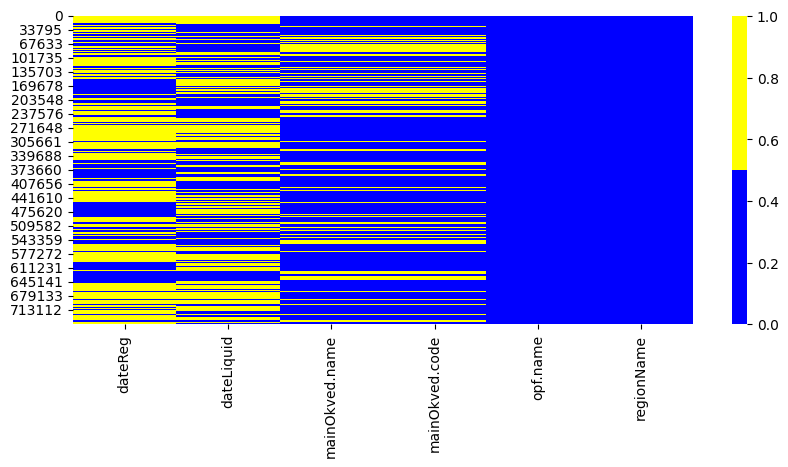

In [211]:
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(10, 4))
cols = cols_with_null.index
ax = sns.heatmap(
    df[cols].isnull(),
    cmap=sns.color_palette(colors),
)

В некоторых признаках есть пересечения по отсутствующим значениям. Пока избавимся от данных с отсутствующими ОКВЭД и названиями регионов, так как эти признаки критичны для нашей задачи.

In [212]:
df = df.dropna(subset =['mainOkved.name'])

In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 538868 entries, 0 to 747030
Data columns (total 23 columns):
 #   Column                                Non-Null Count   Dtype              
---  ------                                --------------   -----              
 0   regionName                            538860 non-null  object             
 1   fullName                              538868 non-null  object             
 2   ogrn                                  538868 non-null  int64              
 3   egrulStatus                           538868 non-null  object             
 4   regionCode                            538868 non-null  int64              
 5   hasRegionalSupport                    538868 non-null  int64              
 6   statusDetail.shortName                538868 non-null  object             
 7   mainOkved.name                        538868 non-null  object             
 8   mainOkved.code                        538868 non-null  object             
 9   mainOkved

Проверим отсутствующие значения в названиях регионов:

In [214]:
display(df[df['regionName'].isnull()])

,regionName,fullName,ogrn,egrulStatus,regionCode,hasRegionalSupport,statusDetail.shortName,mainOkved.name,mainOkved.code,mainOkved.version,...,incomeDetail.fedSubsidies.totalSum,incomeTotal,opf.code,opf.name,contract_count,contract_sum,originDate,dateOgrn,dateLiquid,dateReg
53316,None,"ЖИЛИЩНО-СТРОИТЕЛЬНЫЙ КООПЕРАТИВ ""СПАРТАК-16""",1031628201560,Ликвидирована,0,0,Действующая,Управление эксплуатацией жилого фонда,70.32.1,ОК 029-2001 (КДЕС Ред. 1),...,0.0,0.0,85,Потребительский кооператив,0,0.0,1969-01-20 00:00:00+00:00,2003-01-17 00:00:00+00:00,2006-05-19 00:00:00+00:00,1969-01-20 00:00:00+00:00
54766,None,"КРЕДИТНЫЙ ПОТРЕБИТЕЛЬСКИЙ КООПЕРАТИВ ГРАЖДАН ""...",1031625401565,Ликвидирована,0,0,Действующая,Предоставление потребительского кредита,65.22.1,ОК 029-2001 (КДЕС Ред. 1),...,0.0,0.0,85,Потребительский кооператив,0,0.0,2003-02-05 00:00:00+00:00,2003-02-05 00:00:00+00:00,2009-03-24 00:00:00+00:00,NaT
68375,None,"ГАРАЖНО-СТРОИТЕЛЬНЫЙ КООПЕРАТИВ ""ЭЛЕМТЭ-3""",1031630221193,Ликвидирована,0,0,Действующая,"Эксплуатация гаражей, стоянок для автотранспор...",63.21.24,ОК 029-2001 (КДЕС Ред. 1),...,0.0,0.0,85,Потребительский кооператив,0,0.0,1997-05-12 00:00:00+00:00,2003-12-08 00:00:00+00:00,2009-06-16 00:00:00+00:00,1997-05-12 00:00:00+00:00
499182,None,"ТОВАРИЩЕСТВО СОБСТВЕННИКОВ ЖИЛЬЯ ""ПОБЕДА""",1041630209279,Ликвидирована,0,0,Действующая,Деятельность органов местного самоуправления п...,75.11.3,ОК 029-2001 (КДЕС Ред. 1),...,0.0,0.0,94,Товарищество собственников жилья,0,0.0,2004-04-28 00:00:00+00:00,2004-04-28 00:00:00+00:00,2007-02-15 00:00:00+00:00,NaT
631662,None,"ЖИЛИЩНО - СТРОИТЕЛЬНЫЙ КООПЕРАТИВ ВОЛГА - 51""",1021603482460,Ликвидирована,0,0,Действующая,"Деятельность прочих общественных организаций, ...",91.33,ОК 029-2001 (КДЕС Ред. 1),...,0.0,0.0,85,Потребительский кооператив,0,0.0,1991-06-24 00:00:00+00:00,2002-12-21 00:00:00+00:00,2006-12-31 00:00:00+00:00,1991-06-24 00:00:00+00:00
632809,None,"ЖИЛИЩНО - СТРОИТЕЛЬНЫЙ КООПЕРАТИВ ""ВОЛГА - 15""",1021603624811,Ликвидирована,0,0,Действующая,Управление эксплуатацией жилого фонда,70.32.1,ОК 029-2001 (КДЕС Ред. 1),...,0.0,0.0,85,Потребительский кооператив,0,0.0,1996-10-31 00:00:00+00:00,2002-11-18 00:00:00+00:00,2006-07-17 00:00:00+00:00,1996-10-31 00:00:00+00:00
633714,None,"ЖИЛИЩНО-СТРОИТЕЛЬНЫЙ КООПЕРАТИВ ""ВОЛГА-24""",1021603481932,Ликвидирована,0,0,Действующая,Управление эксплуатацией жилого фонда,70.32.1,ОК 029-2001 (КДЕС Ред. 1),...,0.0,0.0,85,Потребительский кооператив,0,0.0,1971-10-12 00:00:00+00:00,2002-12-19 00:00:00+00:00,2006-05-17 00:00:00+00:00,1971-10-12 00:00:00+00:00
633758,None,"ЖИЛИЩНО-СТРОИТЕЛЬНЫЙ КООПЕРАТИВ ""КАЗАНКА-18""",1021603483703,Ликвидирована,0,0,Действующая,Управление эксплуатацией жилого фонда,70.32.1,ОК 029-2001 (КДЕС Ред. 1),...,0.0,0.0,85,Потребительский кооператив,0,0.0,1991-09-02 00:00:00+00:00,2002-12-25 00:00:00+00:00,2006-06-14 00:00:00+00:00,1991-09-02 00:00:00+00:00


При них нет и кодов, поэтому можем удалить эти строки.

In [215]:
df = df.dropna(subset =['regionName'])

Среди значений regionName есть значения 'Не определено', им соответствует код региона 99. Заменим, соответственно, название региона на Москву.

In [216]:
df[df['regionCode'] == 99]

,regionName,fullName,ogrn,egrulStatus,regionCode,hasRegionalSupport,statusDetail.shortName,mainOkved.name,mainOkved.code,mainOkved.version,...,incomeDetail.fedSubsidies.totalSum,incomeTotal,opf.code,opf.name,contract_count,contract_sum,originDate,dateOgrn,dateLiquid,dateReg
3277,Не определено,"КРЕДИТНЫЙ ПОТРЕБИТЕЛЬСКИЙ КООПЕРАТИВ ""БОЛЬШОЙ ...",1209900000100,Действует,99,0,Действующая,Деятельность по финансовой взаимопомощи,64.99.6,ОК 029-2014 (КДЕС Ред. 2),...,0.0,0.0,20104,Кредитные потребительские кооперативы,0,0.0,2020-12-28 00:00:00+00:00,2020-12-28 00:00:00+00:00,NaT,NaT
3721,Не определено,БАЙКОНУРСКАЯ ГОРОДСКАЯ ОБЩЕСТВЕННАЯ ОРГАНИЗАЦИ...,1205000106970,Действует,99,0,Действующая,"Деятельность прочих общественных организаций, ...",94.99,ОК 029-2014 (КДЕС Ред. 2),...,0.0,0.0,20200,Общественные организации,0,0.0,2020-11-20 00:00:00+00:00,2020-11-20 00:00:00+00:00,NaT,NaT
35939,Не определено,"ОБЩЕСТВЕННАЯ ОРГАНИЗАЦИЯ ""БАЙКОНУРСКАЯ ФЕДЕРАЦ...",1095000003977,Ликвидирована,99,0,Действующая,"Деятельность прочих общественных организаций, ...",94.99,ОК 029-2014 (КДЕС Ред. 2),...,0.0,0.0,0,ОБЩЕСТВЕННАЯ ОРГАНИЗАЦИЯ,0,0.0,2009-07-30 00:00:00+00:00,2009-07-30 00:00:00+00:00,2017-10-11 00:00:00+00:00,NaT
53752,Не определено,"ПОТРЕБИТЕЛЬСКИЙ КООПЕРАТИВ ""ГАРАЖНО-СТРОИТЕЛЬН...",1039923000974,Ликвидирована,99,0,Действующая,Хранение и складирование,63.12,ОК 029-2001 (КДЕС Ред. 1),...,0.0,0.0,85,Потребительский кооператив,0,0.0,2002-05-27 00:00:00+00:00,2003-05-20 00:00:00+00:00,2011-02-18 00:00:00+00:00,2002-05-27 00:00:00+00:00
57799,Не определено,"ПОТРЕБИТЕЛЬСКИЙ КООПЕРАТИВ ""ГАРАЖНО-СТРОИТЕЛЬН...",1039923001535,Действует,99,0,Действующая,Деятельность стоянок для транспортных средств,52.21.24,ОК 029-2014 (КДЕС Ред. 2),...,0.0,0.0,20101,Гаражные и гаражно-строительные кооперативы,0,0.0,2000-12-19 00:00:00+00:00,2003-09-12 00:00:00+00:00,NaT,2000-12-19 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712352,Не определено,ПРОФСОЮЗНАЯ ОРГАНИЗАЦИЯ РАБОТНИКОВ ГОСУДАРСТВЕ...,1055000008139,Ликвидирована,99,0,Действующая,Деятельность профессиональных союзов,94.20,ОК 029-2014 (КДЕС Ред. 2),...,0.0,0.0,20202,Профсоюзные организации,0,0.0,2005-05-19 00:00:00+00:00,2005-05-19 00:00:00+00:00,2019-07-12 00:00:00+00:00,NaT
733025,Не определено,"ПОТРЕБИТЕЛЬСКИЙ КООПЕРАТИВ ""ГАРАЖНО-СТРОИТЕЛЬН...",1059930305192,Ликвидирована,99,0,Действующая,"Эксплуатация гаражей, стоянок для автотранспор...",63.21.24,ОК 029-2001 (КДЕС Ред. 1),...,0.0,0.0,85,Потребительский кооператив,0,0.0,2005-08-17 00:00:00+00:00,2005-08-17 00:00:00+00:00,2011-02-18 00:00:00+00:00,NaT
733931,Не определено,"ПОТРЕБИТЕЛЬСКИЙ КООПЕРАТИВ ""ГАРАЖНО-СТРОИТЕЛЬН...",1059930301947,Действует,99,0,Действующая,Деятельность стоянок для транспортных средств,52.21.24,ОК 029-2014 (КДЕС Ред. 2),...,0.0,0.0,20101,Гаражные и гаражно-строительные кооперативы,0,0.0,2005-04-26 00:00:00+00:00,2005-04-26 00:00:00+00:00,NaT,NaT
736036,Не определено,"ПОТРЕБИТЕЛЬСКИЙ КООПЕРАТИВ ""ГАРАЖНО-СТРОИТЕЛЬН...",1059930306336,Действует,99,0,Действующая,Деятельность стоянок для транспортных средств,52.21.24,ОК 029-2014 (КДЕС Ред. 2),...,0.0,0.0,20101,Гаражные и гаражно-строительные кооперативы,0,0.0,2005-11-29 00:00:00+00:00,2005-11-29 00:00:00+00:00,NaT,NaT


In [217]:
df.loc[df['regionCode'] == 99, 'regionName'] = 'Москва'

In [218]:
#заменим код 99 на 77, чтобы везде обозначения региона "Москва" были одинаковыми
df['regionCode'] = df['regionCode'].apply(lambda x: 77 if x==99 else x)

In [219]:
df['regionCode'].min() #прверим, нет ли больше 0-го регионального кода, то есть отсутствующего значения

1

У нас есть две даты создания организации - dateReg (для организаций, зарегистрированных до 2002 года) и originDate - просто дата возникновения. Проверим, совпадают ли эти даты:

In [220]:
notnaReg = df[df['dateReg'].notna()]
notnaReg[notnaReg['dateReg'] != notnaReg['originDate']]
#все существующие значения dateReg совпадают с originDate, поэтому можно удалить dateReg

,regionName,fullName,ogrn,egrulStatus,regionCode,hasRegionalSupport,statusDetail.shortName,mainOkved.name,mainOkved.code,mainOkved.version,...,incomeDetail.fedSubsidies.totalSum,incomeTotal,opf.code,opf.name,contract_count,contract_sum,originDate,dateOgrn,dateLiquid,dateReg


In [221]:
df = df.drop(columns=['dateReg'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 538860 entries, 0 to 747030
Data columns (total 22 columns):
 #   Column                                Non-Null Count   Dtype              
---  ------                                --------------   -----              
 0   regionName                            538860 non-null  object             
 1   fullName                              538860 non-null  object             
 2   ogrn                                  538860 non-null  int64              
 3   egrulStatus                           538860 non-null  object             
 4   regionCode                            538860 non-null  int64              
 5   hasRegionalSupport                    538860 non-null  int64              
 6   statusDetail.shortName                538860 non-null  object             
 7   mainOkved.name                        538860 non-null  object             
 8   mainOkved.code                        538860 non-null  object             
 9   mainOkved

## Feature Engineering

Посмотрим на самую старую и самую новую даты регистрации НКО.

In [222]:
print(df['originDate'].min())
print(df['originDate'].max())

1881-01-29 00:00:00+00:00
2021-08-19 00:00:00+00:00


Что касается самой старой даты, то, возможно это ошибка или выброс.

In [223]:
display(df[df['originDate']=='1881-01-29 00:00:00+00:00']) #проверим, что это за организация

,regionName,fullName,ogrn,egrulStatus,regionCode,hasRegionalSupport,statusDetail.shortName,mainOkved.name,mainOkved.code,mainOkved.version,...,incomeDetail.fedSubsidies.totalCount,incomeDetail.fedSubsidies.totalSum,incomeTotal,opf.code,opf.name,contract_count,contract_sum,originDate,dateOgrn,dateLiquid
37554,Московская область,"САДОВОДЧЕСКОЕ НЕКОММЕРЧЕСКОЕ ТОВАРИЩЕСТВО ""ПРО...",1025003747504,Ликвидирована,50,0,Действующая,Управление эксплуатацией нежилого фонда за воз...,68.32.2,ОК 029-2014 (КДЕС Ред. 2),...,0,0.0,0.0,20701,"Садоводческие, огороднические или дачные неком...",0,0.0,1881-01-29 00:00:00+00:00,2002-07-26 00:00:00+00:00,2019-08-27 00:00:00+00:00


Теперь создадим признак 'age' - возраст организации, исходя из даты актуальности данных - 26 августа 2021 года:

In [224]:
reference_date = pytz.UTC.localize(datetime(2021,8,26)) #закрепляем актуальную дату
reference_date

datetime.datetime(2021, 8, 26, 0, 0, tzinfo=<UTC>)

In [225]:
df['originDate'].dtype

datetime64[ns, UTC]

In [226]:
mask_active = df['dateLiquid'].isna() #создаем маску для действующих организаций
df.loc[mask_active,'age'] = (reference_date-df.loc[mask_active,'originDate']) #считаем их возраст
mask_liquidated = ~df['dateLiquid'].isna() #создаем маску для ликвидированных организаций
df.loc[mask_liquidated,'age'] = (df.loc[mask_liquidated,'dateLiquid'] - df.loc[mask_liquidated,'originDate']) #считаем их возраст
df['age'] = df['age'].dt.days
df['age'] = df['age']/365.25 #переведем возраст в годы
print(df[['originDate', 'dateLiquid','age']])
print('Lacks in age:',df['age'].isnull().sum())

                      originDate                dateLiquid       age
0      2020-10-30 00:00:00+00:00                       NaT  0.821355
1      2020-09-23 00:00:00+00:00                       NaT  0.922656
2      2020-02-03 00:00:00+00:00                       NaT  1.560575
3      2020-09-23 00:00:00+00:00                       NaT  0.922656
4      2020-07-08 00:00:00+00:00                       NaT  1.133470
...                          ...                       ...       ...
747026 2006-03-29 00:00:00+00:00 2011-07-15 00:00:00+00:00  5.295003
747027 2006-07-07 00:00:00+00:00 2014-09-10 00:00:00+00:00  8.177960
747028 2006-03-22 00:00:00+00:00 2007-12-17 00:00:00+00:00  1.738535
747029 2006-03-29 00:00:00+00:00 2009-01-12 00:00:00+00:00  2.792608
747030 2006-08-09 00:00:00+00:00 2012-08-15 00:00:00+00:00  6.017796

[538860 rows x 3 columns]
Lacks in age: 0


Посмотрим как распределен возраст организаций:

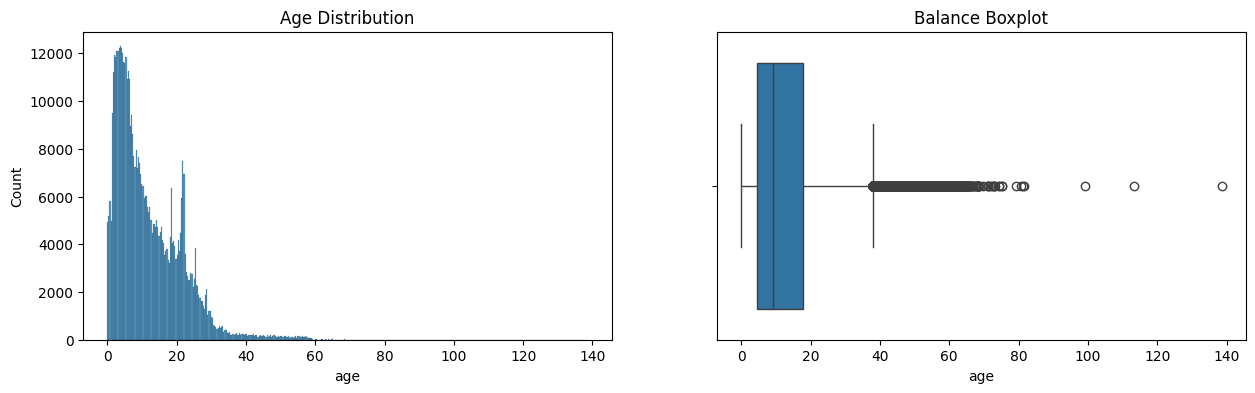

In [227]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='age', ax=axes[0]);
histplot.set_title('Age Distribution');
boxplot = sns.boxplot(data=df, x='age', ax=axes[1]);
boxplot.set_title('Balance Boxplot');

In [323]:
with open('age_distrib.pkl', 'wb') as output:
    pickle.dump(fig, output)

Видим, что в основном, возраст НКО до 20 лет. Есть резкий взрыв - примерно 20-25 лет назад, когда их создавалось достаточно много, и далее после спада постепенный рост в течение последнего десятилетия со снижением в ковидные времена.

Разделим возраст на интервалы и создадим категориальную переменную:

In [228]:
def age_group(x):
    if x < 5:
      return 1
    elif 5 <= x < 10:
      return 2
    elif 10 <= x < 20:
      return 3
    elif 20 <= x < 40:
      return 4
    elif x >= 40:
      return 5

df['age_group'] = df['age'].apply(age_group)

Закодируем ОКВЕД в удобную для анализа числовую форму, основываясь пока на основном коде деятельности, то есть первой цифре до точки.

In [229]:
#создаем новый признак, значениями которго будут основные коды оквэд в числовом формате
df['okved_short'] = df['mainOkved.code'].str.split('.').str[0].astype('int64') 
df[['mainOkved.code','okved_short']] #проверяем результат

,mainOkved.code,okved_short
0,94.12,94
1,64.99,64
2,69.10,69
3,68.32,68
4,82.30,82
...,...,...
747026,15.51,15
747027,65.22,65
747028,15.51,15
747029,70.32,70


In [230]:
len(df['okved_short'].unique()) #проверяем количество получившихся категорий

88

Категорий много, но в отличие от регионов пока, мы можем сформировать из них группы, руководствуясь описанием кодов и делением их на разделы. Данные можно взять здесь https://www.consultant.ru/document/cons_doc_LAW_163320/ 

In [231]:
def okved_group_name(x):
    if x < 5:
      return 'Сельское хозяйство'
    elif 5 <= x < 10:
      return 'Полезные ископаемые'
    elif 10 <= x < 35:
      return 'Производство'
    elif x == 35:
      return 'Обеспечение энергией'
    elif 36 <= x < 41:
      return 'Водоснабжение'
    elif 31 <= x < 45:
        return 'Строительство'
    elif 35 <= x < 49:
        return 'Торговля'
    elif 49 <= x < 55:
        return 'Транспортировка и хранение'
    elif 55 <= x < 58:
        return 'Гостиницы и общественное питание'
    elif 58 <= x < 64:
        return 'СМИ'
    elif 54 <= x < 68:
        return 'Финансы и страхование'
    elif x == 68:
        return 'Операции с недвижимостью'
    elif 69 <= x < 77:
        return 'Научная и техническая деятельность'
    elif 77 <= x < 84:
        return 'Административно-хозяйственная деятельность'
    elif x == 84:
        return 'Военная безопасность, соцобеспечение'
    elif x == 85:
        return 'Образование'
    elif 86 <= x < 90:
        return 'Здравоохранение'
    elif 90 <= x < 94:
        return 'Культура, спорт, развлечения'
    elif 94 <= x < 97:
        return 'Прочее, персональные и бытовые услуги'
    elif 97 <= x < 99:
        return 'Домашние хозяйства'
    elif x == 99:
        return 'Экстерриториальная деятельность'
    

df['okved_group_name'] = df['okved_short'].apply(okved_group_name)

Закодируем группы:

In [232]:
def okved_group_code(x):
    if x < 5:
      return 1
    elif 5 <= x < 10:
      return 2
    elif 10 <= x < 35:
      return 3
    elif x == 35:
      return 4
    elif 36 <= x < 41:
      return 5
    elif 31 <= x < 45:
        return 6
    elif 35 <= x < 49:
        return 7
    elif 49 <= x < 55:
        return 8
    elif 55 <= x < 58:
        return 9
    elif 58 <= x < 64:
        return 10
    elif 54 <= x < 68:
        return 11
    elif x == 68:
        return 12
    elif 69 <= x < 77:
        return 13
    elif 77 <= x < 84:
        return 14
    elif x == 84:
        return 15
    elif x == 85:
        return 16
    elif 86 <= x < 90:
        return 17
    elif 90 <= x < 94:
        return 18
    elif 94 <= x < 97:
        return 19
    elif 97 <= x < 99:
        return 20
    elif x == 99:
        return 21
    

df['okved_group_code'] = df['okved_short'].apply(okved_group_code)

In [233]:
df.head()

,regionName,fullName,ogrn,egrulStatus,regionCode,hasRegionalSupport,statusDetail.shortName,mainOkved.name,mainOkved.code,mainOkved.version,...,contract_count,contract_sum,originDate,dateOgrn,dateLiquid,age,age_group,okved_short,okved_group_name,okved_group_code
0,Санкт-Петербург,МЕЖРЕГИОНАЛЬНАЯ АНТРОПОСОФСКАЯ МЕДИЦИНСКАЯ АСС...,1207800141790,Действует,78,0,Действующая,Деятельность профессиональных членских организ...,94.12,ОК 029-2014 (КДЕС Ред. 2),...,0,0.0,2020-10-30 00:00:00+00:00,2020-10-30 00:00:00+00:00,NaT,0.821355,1,94,"Прочее, персональные и бытовые услуги",19
1,Москва,"ФОНД ""СОДЕЙСТВИЕ ДУХОВНОМУ РАЗВИТИЮ ЧЕЛОВЕКА ""...",1207700349152,Действует,77,0,Действующая,"Предоставление прочих финансовых услуг, кроме ...",64.99,ОК 029-2014 (КДЕС Ред. 2),...,0,0.0,2020-09-23 00:00:00+00:00,2020-09-23 00:00:00+00:00,NaT,0.922656,1,64,Финансы и страхование,11
2,Санкт-Петербург,"КОЛЛЕГИЯ АДВОКАТОВ ""САНКТ-ПЕТЕРБУРГСКАЯ КОЛЛЕГ...",1207800011430,Действует,78,0,Действующая,Деятельность в области права,69.10,ОК 029-2014 (КДЕС Ред. 2),...,0,0.0,2020-02-03 00:00:00+00:00,2020-02-03 00:00:00+00:00,NaT,1.560575,1,69,Научная и техническая деятельность,13
3,Москва,"ТОВАРИЩЕСТВО СОБСТВЕННИКОВ НЕДВИЖИМОСТИ ""ЛУГИН...",1207700348976,Действует,77,0,Действующая,Управление недвижимым имуществом за вознагражд...,68.32,ОК 029-2014 (КДЕС Ред. 2),...,0,0.0,2020-09-23 00:00:00+00:00,2020-09-23 00:00:00+00:00,NaT,0.922656,1,68,Операции с недвижимостью,12
4,Санкт-Петербург,"АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ""ЦЕНТР С...",1207800081500,Действует,78,0,Действующая,Деятельность по организации конференций и выст...,82.30,ОК 029-2014 (КДЕС Ред. 2),...,0,0.0,2020-07-08 00:00:00+00:00,2020-07-08 00:00:00+00:00,NaT,1.133470,1,82,Административно-хозяйственная деятельность,14


Так как перед нами стоит задача изучить вероятность получения грантов/госконтрактов в зависимости от некоторых признаков, то создадим соответствующую бинарную целевую переменную.

Суммируем для простоты гранты, субсидии и контракты. 

In [234]:
df['totalSupportCount'] = df['incomeDetail.fedSubsidies.totalCount']+df['incomeDetail.grants.totalCount']+df['contract_count']
df['totalSupportSum'] = df['incomeDetail.fedSubsidies.totalSum']+df['incomeDetail.grants.totalSum']+df['contract_sum']

In [235]:
# создаем бинарный целевой признак
df['has_state_support'] = df['totalSupportCount'].apply(lambda x: 1 if x != 0 else 0)

В данных есть признак incomeTotal. Сравним его значения с теми, что получились в признаке totalSupportSum:

In [236]:
df_has = df[df['has_state_support'] >0]
len(df_has[df_has['has_state_support'] != df_has['incomeTotal']])

33218

По большей части суммы совпали, но есть расхождения. Посмотрим, отличаются ли количества нулевых сумм.

In [237]:
income_zero = df[df['incomeTotal']==0]
len(income_zero)

505733

In [238]:
izn = income_zero[['contract_sum','contract_count','has_state_support','totalSupportCount']]

In [239]:
izn[izn['has_state_support']==1]

,contract_sum,contract_count,has_state_support,totalSupportCount
17409,0.0,1,1,1
21398,0.0,1,1,1
24730,0.0,1,1,1
48447,0.0,2,1,2
100821,0.0,1,1,1
...,...,...,...,...
709302,0.0,1,1,1
709935,0.0,1,1,1
710044,0.0,1,1,1
710501,0.0,1,1,1


Видно, по некоторым НКО указаны контракты, но не указана сумма. Поэтому есть расхождения. Оставим целевой признак сформированным на основании наличия договора, а не суммы.

Проверяем, насколько сбалансированы классы целевого признака:

<Axes: xlabel='has_state_support', ylabel='count'>

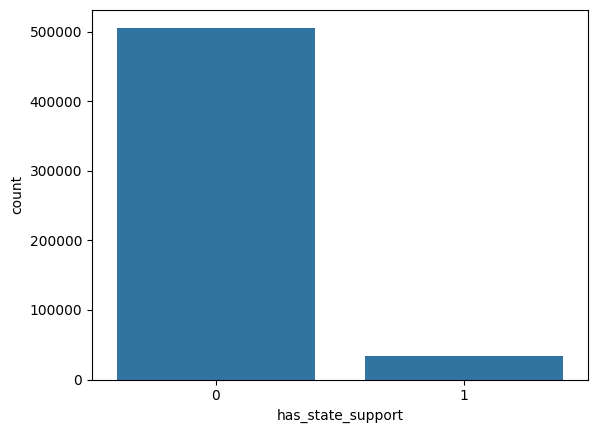

In [240]:
df['has_state_support'].value_counts()
sns.countplot(data=df, x='has_state_support')

Классы получились с сильным дисбалансом

Чтобы справиться с дисбалансом воспользуемся впоследствии стратифицированным разбиением на выборки. Для стратифицированного разбиения достаточно в функции train_test_split() задать параметр stratify, в который нужно передать столбец с метками классов, на основе которого будет производиться балансировка. Это будет столбец с правильными ответами y.

Посмотрим на распределение общих сумм поддержки.

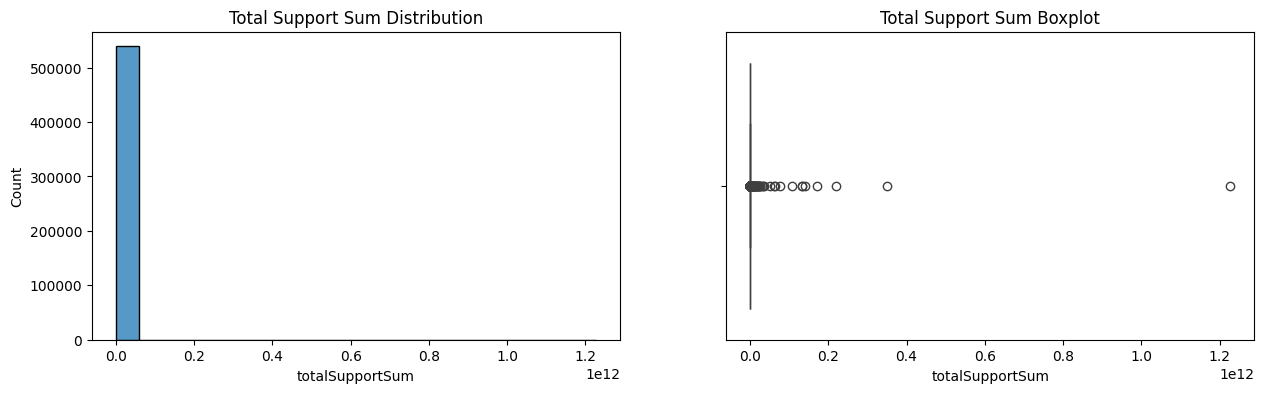

In [241]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='totalSupportSum', ax=axes[0]);
histplot.set_title('Total Support Sum Distribution');
boxplot = sns.boxplot(data=df, x='totalSupportSum', ax=axes[1]);
boxplot.set_title('Total Support Sum Boxplot');

Пока оставим потенциальные выбросы в данных, так как нас интересует факт получения контракта, гранта или субсидии.

In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 538860 entries, 0 to 747030
Data columns (total 30 columns):
 #   Column                                Non-Null Count   Dtype              
---  ------                                --------------   -----              
 0   regionName                            538860 non-null  object             
 1   fullName                              538860 non-null  object             
 2   ogrn                                  538860 non-null  int64              
 3   egrulStatus                           538860 non-null  object             
 4   regionCode                            538860 non-null  int64              
 5   hasRegionalSupport                    538860 non-null  int64              
 6   statusDetail.shortName                538860 non-null  object             
 7   mainOkved.name                        538860 non-null  object             
 8   mainOkved.code                        538860 non-null  object             
 9   mainOkved

ОПФ - это организационно правовая форма. Их всего в таблице 140 разных категорий. Но так как у нас есть список категорий, относящихся к фондам, то можем создать бинарный признак фонд/не фонд.

In [243]:
print(len(df['opf.code'].unique()))

140


Кроме списка фондов в отдельной таблице, в нашем датасете среди кодов, относящихся к фондам есть 88, добавим и его в список.

In [244]:
funds = df[df['opf.name']=="Фонд"]
funds['opf.code']

50104     88
50220     88
50288     88
50335     88
50418     88
          ..
746911    88
746957    88
746992    88
747022    88
747030    88
Name: opf.code, Length: 6761, dtype: int64

In [245]:
fund_codes = f_codes['okopf_id'].unique().tolist()+[88]
fund_codes

[70400, 70401, 70403, 70402, 70404, 88]

Сформируем еще один бинарный признак - фонд/не фонд.

In [246]:
df['is_fund'] = df['opf.code'].apply(lambda x: 1 if x in fund_codes else 0)

In [247]:
#проверяем 
df[['is_fund','opf.code']]

,is_fund,opf.code
0,0,20600
1,1,70400
2,0,20616
3,0,20700
4,0,71400
...,...,...
747026,0,85
747027,0,85
747028,0,85
747029,0,94


## Анализ зависимостей и статистические тесты

In [248]:
region_funding = df.groupby('regionName')['has_state_support'].mean().sort_values(ascending=False)
print(region_funding.head(10)) #топ 10 регионов по доле финансирования

regionName
Санкт-Петербург                             0.106057
Ненецкий автономный округ                   0.104530
Пермский край                               0.090850
Ханты-Мансийский автономный округ - Югра    0.090796
Амурская область                            0.090656
Москва                                      0.090014
Новгородская область                        0.085714
Республика Алтай                            0.084882
Ямало-Ненецкий автономный округ             0.082139
Волгоградская область                       0.079447
Name: has_state_support, dtype: float64


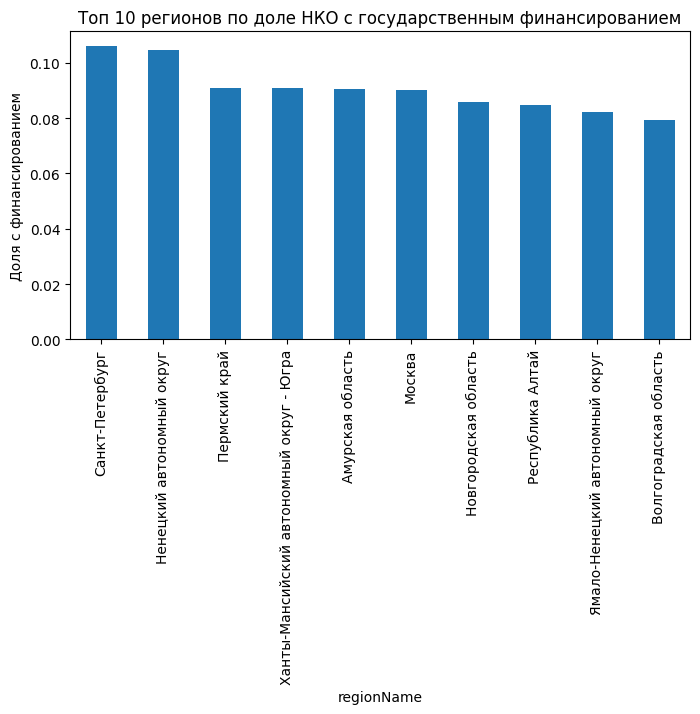

In [249]:
region_funding.head(10).plot(kind='bar', figsize=(8,4), title = "Топ 10 регионов по доле НКО с государственным финансированием")
plt.xticks(rotation=90)
plt.ylabel ('Доля с финансированием')
plt.show()

Самое большое количество получаемых грантов/контрактов от государства в Санкт-Петербурге, Ненецком автономном округе и Пермском крае.

In [250]:
age_funding = df.groupby('age_group')['has_state_support'].mean().sort_index()
age_funding

age_group
1    0.027298
2    0.061768
3    0.093450
4    0.071552
5    0.025894
Name: has_state_support, dtype: float64

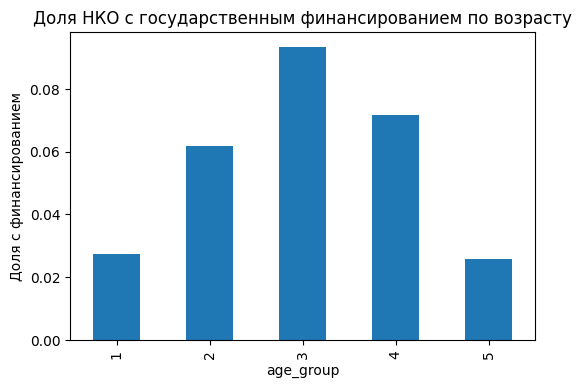

In [251]:
age_funding.plot(kind='bar',figsize=(6,4),title='Доля НКО с государственным финансированием по возрасту')
plt.ylabel('Доля с финансированием')
plt.show()

Больше всего грантов/контрактов от государства получают НКО, существующие 10-20 лет и, однако, линейной зависимости нет: доля, получивших господдержку организаций, старше 40 лет, меньше всех остальных

In [252]:
okved_funding = df.groupby('okved_group_name')['has_state_support'].mean().sort_values(ascending=False)
print(okved_funding.head(10))

okved_group_name
Гостиницы и общественное питание         0.296095
Образование                              0.221893
Здравоохранение                          0.148165
Водоснабжение                            0.129167
Торговля                                 0.128705
СМИ                                      0.106871
Производство                             0.104403
Военная безопасность, соцобеспечение     0.086387
Прочее, персональные и бытовые услуги    0.070714
Экстерриториальная деятельность          0.062500
Name: has_state_support, dtype: float64


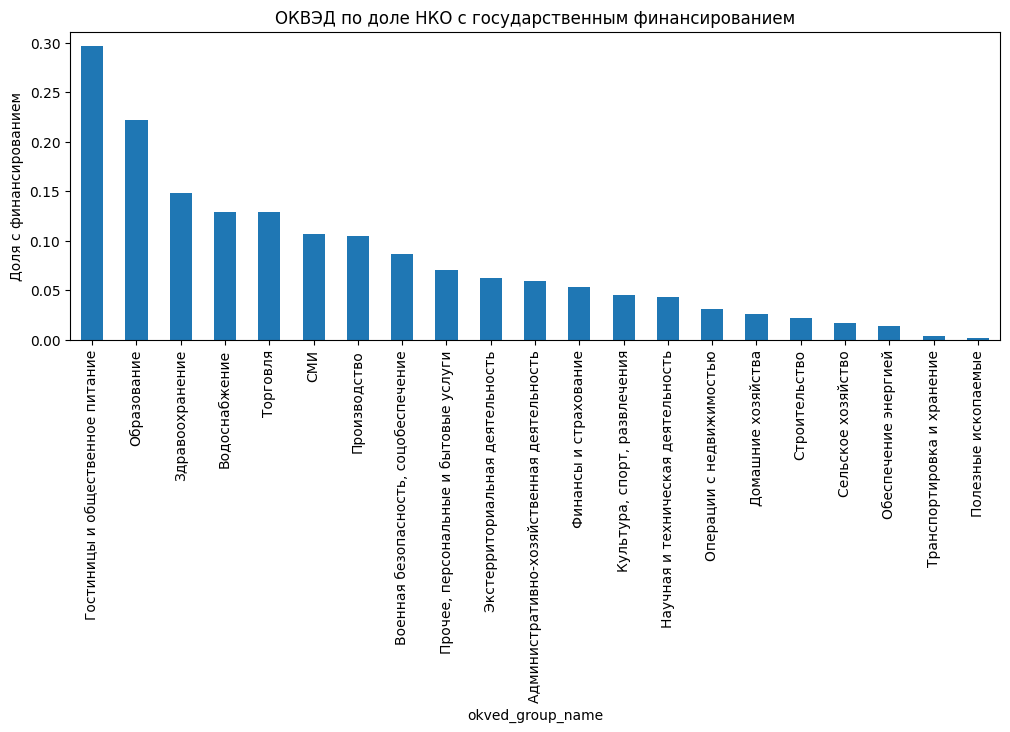

In [253]:
okved_funding.plot(kind='bar',figsize=(12,4),title='ОКВЭД по доле НКО с государственным финансированием')
plt.ylabel('Доля с финансированием')
plt.show()

Наибольшую поддержку от государства получают НКО в области организации гостинчного бизнеса, питания, образования и здравоохранения.

Чтобы ответить на вопрос, поставленный в задаче, проведем статистический тест на значимую связь между целевой переменной и интересующими нас признаками.

In [254]:
def chi2_result(feature_to_compare):
    alpha = 0.05
    #вычисляем таблицу сопряжённости
    table = pd.crosstab(df[feature_to_compare], df['has_state_support'])
    chi2, p_value, dof, expected = chi2_contingency(table)
# интерпретируем результат
    if p_value <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу: существует статистически значимая ассоциация между признаками'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
    print(f'Статистика хи-квадрат: {chi2:.4f}')
    print(f'p-value: {p_value:.4f}')   

In [255]:
chi2_result('age_group')

p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу: существует статистически значимая ассоциация между признаками
Статистика хи-квадрат: 5980.8072
p-value: 0.0000


In [256]:
chi2_result('regionCode')

p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу: существует статистически значимая ассоциация между признаками
Статистика хи-квадрат: 3385.4525
p-value: 0.0000


In [257]:
chi2_result('okved_group_code')

p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу: существует статистически значимая ассоциация между признаками
Статистика хи-квадрат: 22912.4536
p-value: 0.0000


По всем трем признакам статистический тест показал существующую зависимость. Однако, пока не торопимся с выводами.

In [258]:
df.columns

Index(['regionName', 'fullName', 'ogrn', 'egrulStatus', 'regionCode',
       'hasRegionalSupport', 'statusDetail.shortName', 'mainOkved.name',
       'mainOkved.code', 'mainOkved.version', 'incomeDetail.grants.totalCount',
       'incomeDetail.grants.totalSum', 'incomeDetail.fedSubsidies.totalCount',
       'incomeDetail.fedSubsidies.totalSum', 'incomeTotal', 'opf.code',
       'opf.name', 'contract_count', 'contract_sum', 'originDate', 'dateOgrn',
       'dateLiquid', 'age', 'age_group', 'okved_short', 'okved_group_name',
       'okved_group_code', 'totalSupportCount', 'totalSupportSum',
       'has_state_support', 'is_fund'],
      dtype='object')

## Построение модели и контроль качества

Построим корреляционную матрицу. В качестве статистического метода выберем корреляцию Спирмена, так как она подходит для нелинейных зависимостей.

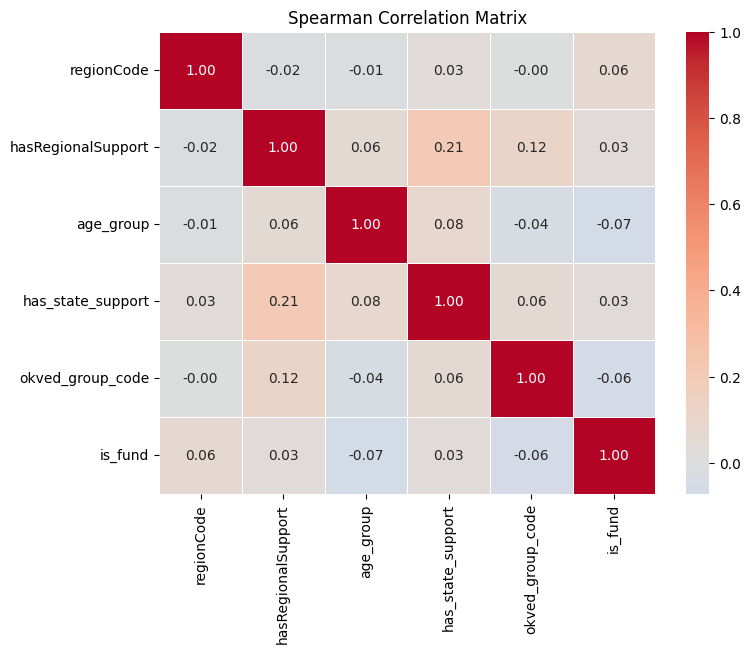

In [259]:
df_final = df[['regionCode','hasRegionalSupport','age_group','has_state_support','okved_group_code','is_fund']]
correlation_matrix = df_final.corr(method='spearman')
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix,annot=True,cmap='coolwarm',center=0, fmt='.2f',linewidths=0.5)
plt.title('Spearman Correlation Matrix')
plt.show()

В матрице корреляций нет мультиколлинеарности, есть небольшие зависимости

In [260]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 538860 entries, 0 to 747030
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   regionCode          538860 non-null  int64
 1   hasRegionalSupport  538860 non-null  int64
 2   age_group           538860 non-null  int64
 3   has_state_support   538860 non-null  int64
 4   okved_group_code    538860 non-null  int64
 5   is_fund             538860 non-null  int64
dtypes: int64(6)
memory usage: 28.8 MB


Закодируем признаки age_group, region_code, okved_group_code с помощью LabelEncoder

In [261]:
l_encoder = LabelEncoder()
encoded = l_encoder.fit_transform(df_final['age_group'])
df_final = df_final.drop(columns='age_group')
encoded = pd.DataFrame(encoded, index=df_final.index, columns=['age_group'])
df_final = pd.concat([df_final, encoded], axis=1)

In [264]:
l_encoder = LabelEncoder()
encoded = l_encoder.fit_transform(df_final['okved_group_code'])
df_final = df_final.drop(columns='okved_group_code')
encoded = pd.DataFrame(encoded, index=df_final.index, columns=['okved_group_code'])
df_final = pd.concat([df_final, encoded], axis=1)

In [266]:
l_encoder = LabelEncoder()
encoded = l_encoder.fit_transform(df_final['regionCode'])
df_final = df_final.drop(columns='regionCode')
encoded = pd.DataFrame(encoded, index=df_final.index, columns=['regionCode'])
df_final = pd.concat([df_final, encoded], axis=1)

Еще раз посмотрим на приоритет корреляций

In [269]:
to_viz = df_final.corr()['has_state_support'].sort_values(ascending=False) 

In [271]:
display(to_viz)
fig = px.bar(to_viz)
fig.show()

has_state_support     1.000000
hasRegionalSupport    0.212650
age_group             0.074267
okved_group_code      0.066635
is_fund               0.032662
regionCode            0.026583
Name: has_state_support, dtype: float64

Разделим данные на тренировочную и тестовую выборки, используем стратифицированный подход, так как классы у нас очень не сбалансированные

In [272]:
X, y = df_final.drop('has_state_support', axis=1), df_final['has_state_support']

In [273]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [274]:
print(X_train.shape)
print(X_test.shape)

(431088, 5)
(107772, 5)


## Baseline 

In [276]:
X_train_copy, X_test_copy = X_train, X_test #оставим копии выборок

In [279]:
# инициализируем нормализатор MinMaxScaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [280]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [281]:
y_train_pred = log_reg.predict(X_train_scaled)
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    404514
           1       0.46      0.02      0.05     26574

    accuracy                           0.94    431088
   macro avg       0.70      0.51      0.51    431088
weighted avg       0.91      0.94      0.91    431088

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    101128
           1       0.46      0.03      0.05      6644

    accuracy                           0.94    107772
   macro avg       0.70      0.51      0.51    107772
weighted avg       0.91      0.94      0.91    107772



В качестве метрики выберем f1 -score. Логистическая регрессия показала очень низкий результат

## Modelling

In [282]:
from sklearn import tree #деревья решений
from sklearn import metrics #метрики
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=3, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model.fit(X_train_scaled, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train_scaled)
y_valid_pred = model.predict(X_test_scaled)
#Выводим значения метрик
print(metrics.classification_report(y_test, y_valid_pred)) 

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    101128
           1       0.52      0.03      0.06      6644

    accuracy                           0.94    107772
   macro avg       0.73      0.52      0.52    107772
weighted avg       0.91      0.94      0.91    107772



Добавим параметр class_weight, который придает веса классам при дисбалансе

In [285]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=3, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
#Обучаем модель на тренировочной выборке
model.fit(X_train_scaled, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train_scaled)
y_valid_pred = model.predict(X_test_scaled)
#Выводим значения метрик
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.80      0.88    404514
           1       0.17      0.63      0.27     26574

    accuracy                           0.79    431088
   macro avg       0.57      0.72      0.58    431088
weighted avg       0.92      0.79      0.84    431088

              precision    recall  f1-score   support

           0       0.97      0.80      0.88    101128
           1       0.17      0.62      0.27      6644

    accuracy                           0.79    107772
   macro avg       0.57      0.71      0.57    107772
weighted avg       0.92      0.79      0.84    107772



Переобучения нет, результат удалось значительно улучшить, но он еще очень низкий.

Попробуем решить задачу с помощью сэмплирования

In [286]:
from imblearn.over_sampling import SMOTE

In [287]:
sm = SMOTE(random_state=2)
X_train_s, y_train_s = sm.fit_resample(X_train_scaled, y_train)

print('Train shape before oversampling:', X_train_scaled.shape) 
print('Class balance before oversampling: \n', y_train.value_counts(), sep='')
print('-'*40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversampling: \n', y_train_s.value_counts(), sep='')

Train shape before oversampling: (431088, 5)
Class balance before oversampling: 
has_state_support
0    404514
1     26574
Name: count, dtype: int64
----------------------------------------
Train shape after oversampling: (809028, 5)
Class balance after oversampling: 
has_state_support
0    404514
1    404514
Name: count, dtype: int64


In [288]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке (с сэмплированием)
model.fit(X_train_s, y_train_s)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train_scaled)
y_valid_pred = model.predict(X_test_scaled)
#Выводим значения метрик    
print(metrics.classification_report(y_test, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.80      0.88    101128
           1       0.17      0.62      0.27      6644

    accuracy                           0.79    107772
   macro avg       0.57      0.71      0.57    107772
weighted avg       0.92      0.79      0.84    107772



Результат не поменялся.

In [289]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел,
    )
#Обучаем модель
model.fit(X_train_scaled, y_train)
#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train_scaled, y_train, cv=skf, method='predict_proba')

display(y_cv_proba_pred)

array([[0.96724596, 0.03275404],
       [0.94766383, 0.05233617],
       [0.94766383, 0.05233617],
       ...,
       [0.66399906, 0.33600094],
       [0.97325701, 0.02674299],
       [0.9590535 , 0.0409465 ]])

In [290]:
#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

In [291]:
#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

Thresholds: [0.         0.0005787  0.00059277 0.00068353 0.00103591]
Precision scores: [0.06164403 0.06202544 0.06208112 0.06214286 0.06224378]
Recall scores: [1.         0.99936028 0.99936028 0.99936028 0.99928502]


Best threshold = 0.17, F1-Score = 0.33


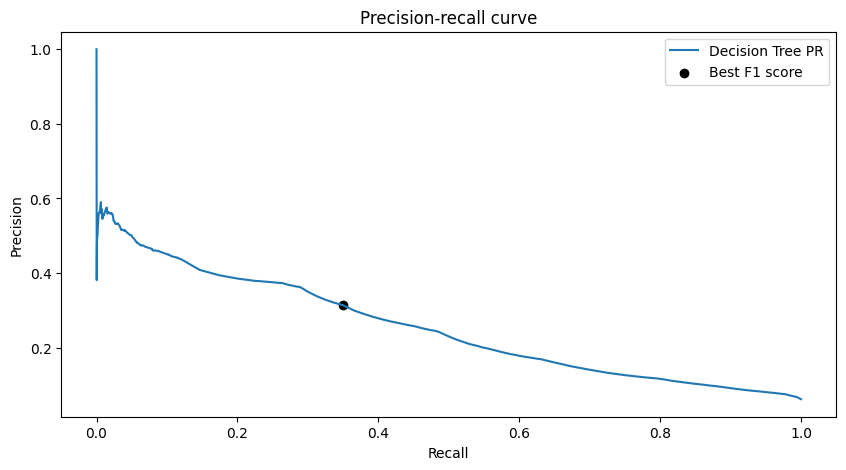

In [292]:
#Вычисляем F1-меру при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))

#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(recall, precision, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(recall[idx], precision[idx], marker='o', color='black', label='Best F1 score')
#Даем графику название и подписи осям
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

In [295]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.17
#НКО, для которых вероятность получить грант/контракт от государства > threshold_opt, относим к классу 1
#В противном случае — к классу 0
y_valid_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_test, y_valid_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95    101128
           1       0.31      0.34      0.32      6644

    accuracy                           0.91    107772
   macro avg       0.63      0.65      0.64    107772
weighted avg       0.92      0.91      0.91    107772



С подбором порога вероятности результат стал немного лучше, но всё еще низкий

In [296]:
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

PR AUC: 0.25


In [315]:
#Создаем объект класса случайный лес
model = ensemble.RandomForestClassifier(
    n_estimators=80,
    max_depth=20,
    criterion='gini',
    min_samples_leaf=5,
    random_state=42
)
model.fit(X_train_scaled, y_train)
#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train_scaled, y_train, cv=skf, method='predict_proba')

display(y_cv_proba_pred)

array([[9.99412619e-01, 5.87381358e-04],
       [9.71755772e-01, 2.82442279e-02],
       [9.18867866e-01, 8.11321340e-02],
       ...,
       [7.92525466e-01, 2.07474534e-01],
       [9.24434509e-01, 7.55654907e-02],
       [9.57691355e-01, 4.23086451e-02]])

In [324]:
rf = pickle.dumps(model)

In [316]:
#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

In [317]:
#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

Thresholds: [0.00000000e+00 1.41322781e-05 1.99680511e-05 2.58196709e-05
 3.24675325e-05]
Precision scores: [0.06164403 0.06184076 0.06184091 0.06185012 0.06188426]
Recall scores: [1.         0.99943554 0.99943554 0.99943554 0.99939791]


Best threshold = 0.19, F1-Score = 0.36


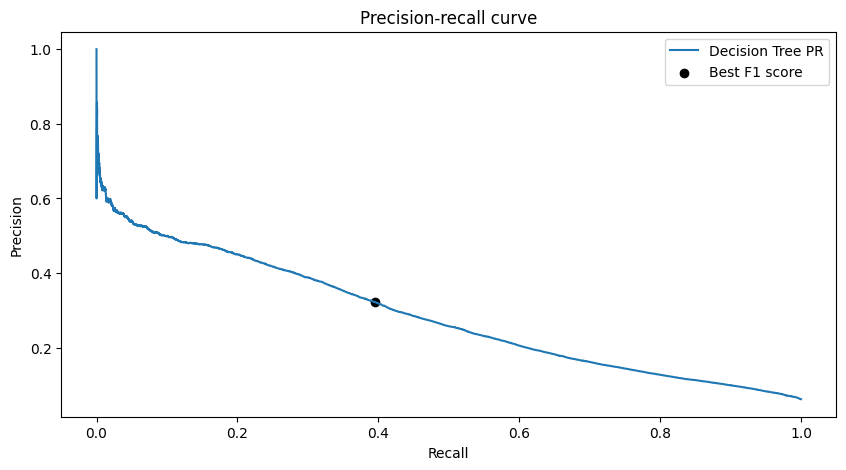

In [318]:
#Вычисляем F1-меру при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))

#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(recall, precision, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(recall[idx], precision[idx], marker='o', color='black', label='Best F1 score')
#Даем графику название и подписи осям
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

In [320]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.19
#НКО, для которых вероятность получить грант/контракт от государства > threshold_opt, относим к классу 1
#В противном случае — к классу 0
y_valid_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_test, y_valid_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95    101128
           1       0.33      0.39      0.36      6644

    accuracy                           0.91    107772
   macro avg       0.64      0.67      0.66    107772
weighted avg       0.92      0.91      0.92    107772



In [314]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_forest.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_forest.score(X_test_scaled, y_test)))
y_test_pred = grid_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 31.4 s
Wall time: 24min 15s
f1_score на обучающем наборе: 0.15
accuracy на тестовом наборе: 0.94
f1_score на тестовом наборе: 0.12
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 80}


Начало сборки пайплайна.

In [327]:
pipe = Pipeline([  
  ('Scaling', scaler),
  ('Classifier', model),
  ('Stratifier', skf),
  ])

Подставим наилучшие значения гиперпараметров в модель выше.

Лучше всего себя показала модель RandomForestClassifier с кросс-валидатором k-fold со стратификацией и подбором порога вероятности, наилучшей результат метрики f1-score - 0.36.

### Выводы:
1. Статистические тесты показали, что между вероятность получения НКО господдержки зависит от региона, возраста и экономической деятельности организации. Но:
2. Три данных признака не являются достаточными для точного предсказания вероятности получения господдержки.
